## Import, prepare and define basics

In [1]:
import os
from subprocess import run
res = run(["git", "rev-parse", "--show-toplevel"], capture_output=True)
root_dir = res.stdout.decode().strip()
os.chdir(root_dir)

In [2]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants as aconst


import disgrid

# %reload_ext autoreload
# %autoreload 2
from importlib import reload
from pprint import pprint
from functools import lru_cache

from disgrid_vorticity import provide_simulation_data, velocity_cartesian_disgrid, velocity_polar_disgrid, roll_data
from src.vortector.vortector import Vortector
from src.vortector.visualize import show_fit_overview_2D

%matplotlib inline

In [3]:
# @lru_cache
def calc_cartesian_velocity(simid, Noutput):
    data = disgrid.NData(simid)
    rv = velocity_cartesian_disgrid(data, Noutput)
    return rv

# @lru_cache
def get_polar_velocity(simid, Noutput):
    data = disgrid.NData(simid)
    rv = velocity_polar_disgrid(data, Noutput)
    return rv

def select_radial_range(nlow, nhigh, *args):
    rv = (x[nlow:nhigh] for x in args)
    return rv

In [75]:
## Select the simulations
# simid = "7446cae5"
simid = "7446cae5"
Noutput = 176
update=False
data = disgrid.NData(simid, update=update)
data.avail()["Nsnapshots"]

501

## Get the data

In [76]:
[key for key in data.avail()["planets"]]

['0', '1']

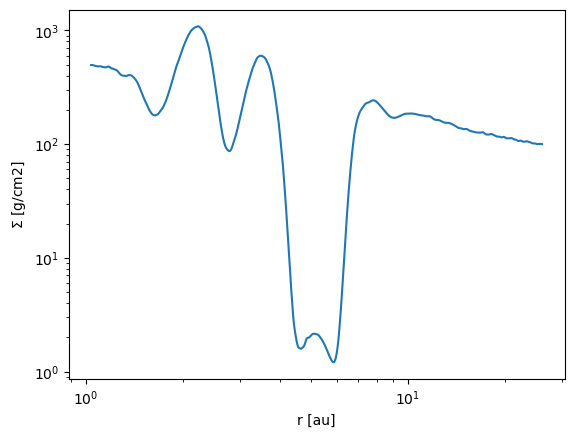

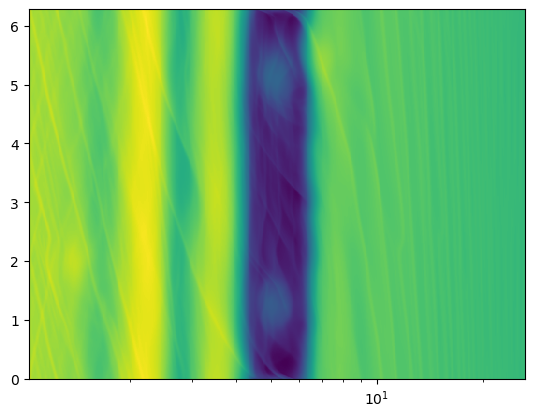

In [77]:
dens = data.get(var="mass density", dim="2d", N=Noutput)

rc = dens.grid.get_centers("r").to_value("au")
sigma1d = np.average(dens.data.to_value("g/cm2"), axis=1)

fig, ax = plt.subplots()

ax.plot(rc, sigma1d)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r [au]")
ax.set_ylabel(r"$\Sigma$ [g/cm2]")


ri = dens.grid.get_interfaces("r").to_value("au")
phii = dens.grid.get_interfaces("phi").to_value("rad")

PHI, R = np.meshgrid(phii, ri)

fig, ax = plt.subplots()

ax.pcolormesh(R, PHI, np.log10(dens.data.to_value("g/cm2")))
ax.set_xscale("log")

Text(0, 0.5, '$v_\\phi/v_K$')

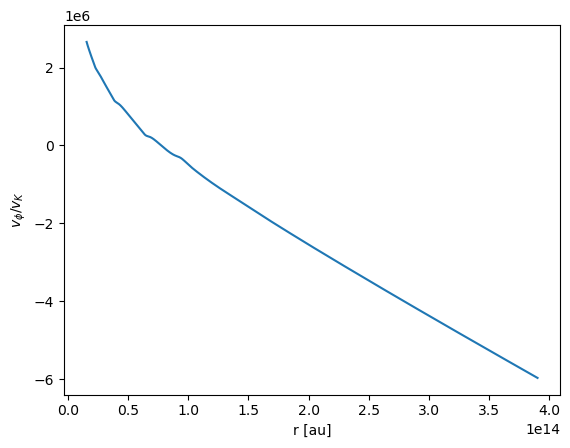

In [78]:
import astropy
fig, ax = plt.subplots()

vphi = data.get(var="velocity azimuthal", dim="2d", N=Noutput)
rc = vphi.grid.get_centers("r").to("cm")
Omega_Kepler = np.sqrt(astropy.constants.G * 1*u.solMass / rc**3).decompose()
vK = Omega_Kepler*rc

vphi_avg = np.average(vphi.data, axis=1)
omega_frame = data.get(var="omega frame", planet=0).data[0]
Vphi_inertial = vphi_avg.to("cm/s") #+  rc.to("cm")*omega_frame.to("1/s")
ax.plot(rc,  Vphi_inertial)
# ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("r [au]")
ax.set_ylabel(r"$v_\phi/v_K$")

# fig, ax = plt.subplots()

# ax.pcolormesh(R, Phi, Vphi)
# ax.set_xscale("log")

In [79]:
vphi_avg

<Quantity [ 2.03577441e+00,  2.02729302e+00,  2.01764931e+00,
            2.00881098e+00,  2.00094055e+00,  1.99372844e+00,
            1.98673373e+00,  1.97959716e+00,  1.97219217e+00,
            1.96447718e+00,  1.95664276e+00,  1.94884016e+00,
            1.94115739e+00,  1.93349616e+00,  1.92566257e+00,
            1.91761805e+00,  1.90951145e+00,  1.90145344e+00,
            1.89365373e+00,  1.88622873e+00,  1.87916400e+00,
            1.87232714e+00,  1.86555035e+00,  1.85866312e+00,
            1.85159024e+00,  1.84433397e+00,  1.83694211e+00,
            1.82943095e+00,  1.82178755e+00,  1.81399811e+00,
            1.80609910e+00,  1.79809448e+00,  1.79000512e+00,
            1.78185299e+00,  1.77368908e+00,  1.76555764e+00,
            1.75748786e+00,  1.74947675e+00,  1.74150711e+00,
            1.73353898e+00,  1.72550199e+00,  1.71733844e+00,
            1.70902739e+00,  1.70058861e+00,  1.69204769e+00,
            1.68340600e+00,  1.67467263e+00,  1.66585448e+00,
        

In [80]:
Rlims = [5.2, 15]


update=True
data = disgrid.NData(simid, update=update)

R, Phi, A, vorticity, vorticity_Kepler, Rho, Rho_background, Nroll = provide_simulation_data(simid, Noutput, skip_cache=update, calc_kwargs={"return_Nroll" : True, "normalize_by" : None})

nl = np.argmin(np.abs(R[:,0]-Rlims[0]))
nr = np.argmin(np.abs(R[:,0]-Rlims[1]))
R, Phi, A, vorticity, vorticity_Kepler, Rho, Rho_background = select_radial_range(nl, nr, R, Phi, A, vorticity, vorticity_Kepler, Rho, Rho_background)

# get cartesian velocitites
X, Y, Vx, Vy = select_radial_range(nl, nr, *calc_cartesian_velocity(simid, Noutput))

# get polar velocities
Vr, Vphi, Vk = select_radial_range(nl, nr, *get_polar_velocity(simid, Noutput))

# calculate Keplerian vorticity
# vorticity_Kepler = Vk.to_value("au/yr")/R/2

Rho0 = Rho_background[:,0]

# get energy
M = Rho*A
try:
    ### Assume its a fargo run
    e_field = data.get(dim="2d", var="energy density", N=Noutput)
    Edens, = select_radial_range(nl, nr, np.roll(e_field.data, Nroll, axis=1))
    Edens = Edens.to_value("solMass/yr2")
    E = Edens*A
    Espec = E/M

    # calculate temperature
    cV = 5/2*aconst.k_B/(2*u.u)
    T = (Espec*(u.au**2/u.yr**2)/cV).decompose()#.to_value("K")

    # calculate pressure
    gamma = 1.4
    h = 0.05
    P = Edens * (gamma-1)


except KeyError:
    ### Propably its a PLUTO run then
    P_field = data.get(dim="2d", var="pressure", N=Noutput)
    P, = select_radial_range(nl, nr, np.roll(P_field.data, Nroll, axis=1))
    P = P.to_value("solMass/yr2")
    
    T = data.get(dim="2d", var="temperature", N=Noutput).data.to_value("K")
    T, = select_radial_range(nl, nr, np.roll(T, Nroll, axis=1))
    
    gamma = 1.4
    h = 0.05
    
# calculate cs2
Cs2_adb = P/Rho
Cs_iso = Vk*0.05
P0 = (Cs_iso.to_value("au/yr")**2)*Rho_background

[[ 2.03577441  2.03577441  2.03577441 ...  2.03577441  2.03577441
   2.03577441]
 [ 2.02411981  2.02404298  2.02393615 ...  2.02443992  2.02429781
   2.02419242]
 [ 2.01816004  2.01825733  2.01839674 ...  2.01807767  2.01814423
   2.01815512]
 ...
 [-4.5075413  -4.50754168 -4.50754209 ... -4.50754034 -4.50754063
  -4.50754095]
 [-4.53951057 -4.53951067 -4.53951079 ... -4.53951044 -4.53951045
  -4.53951049]
 [-4.57211724 -4.57211724 -4.57211724 ... -4.57211724 -4.57211724
  -4.57211724]] 1.30616e+06 cm / s


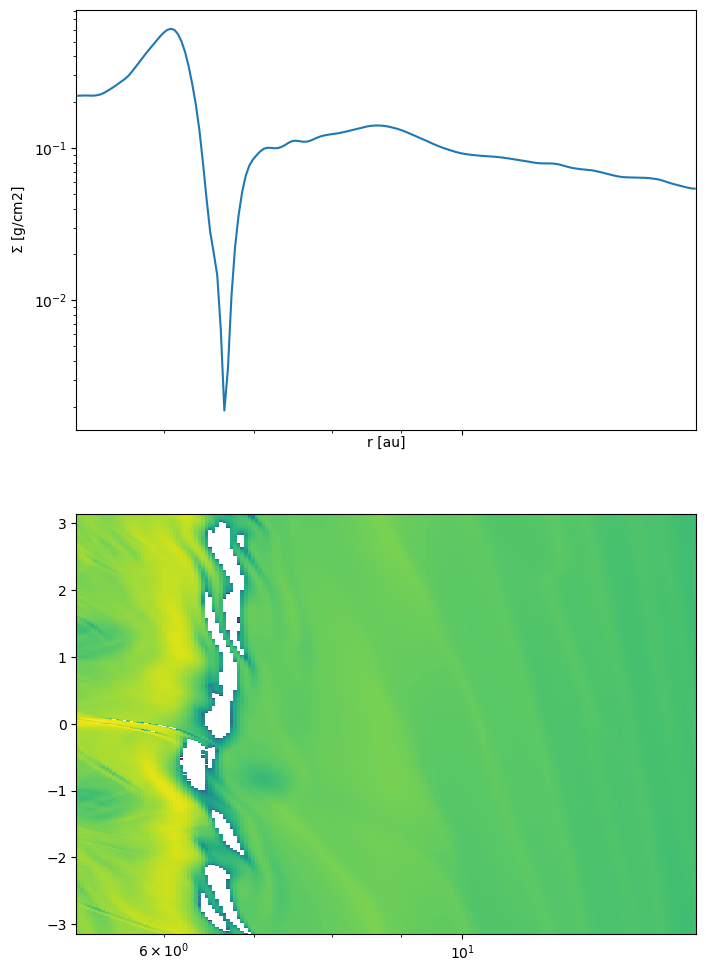

In [81]:
fig, axes = plt.subplots(nrows = 2, sharex="all", figsize=(8,12))

ax = axes[0]
ax.plot(R[:,0], np.average(vorticity, axis=1))
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r [au]")
ax.set_ylabel(r"$\Sigma$ [g/cm2]")

ax = axes[1]
ax.pcolormesh(R, Phi, np.log10(vorticity))
ax.set_xscale("log")

## Vortector plots for vorticity and vortensity 

CPU times: user 272 ms, sys: 76.1 ms, total: 349 ms
Wall time: 100 ms
CPU times: user 400 ms, sys: 262 ms, total: 662 ms
Wall time: 121 ms


Text(0.5, 0.98, 'Vortensity')

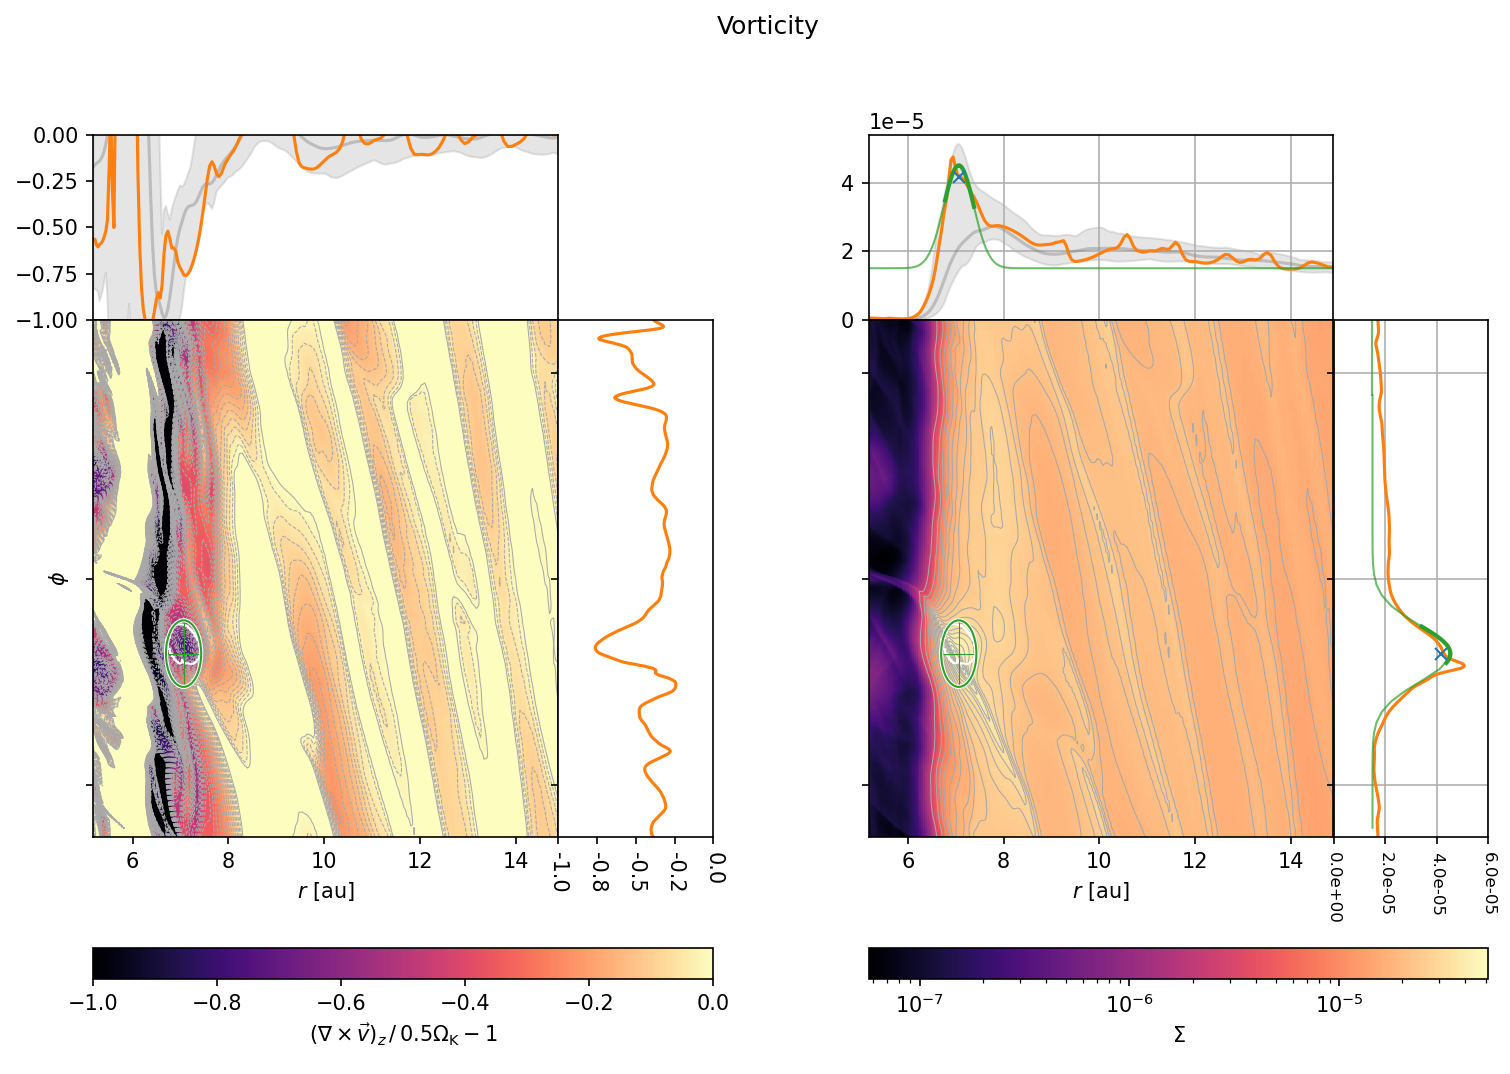

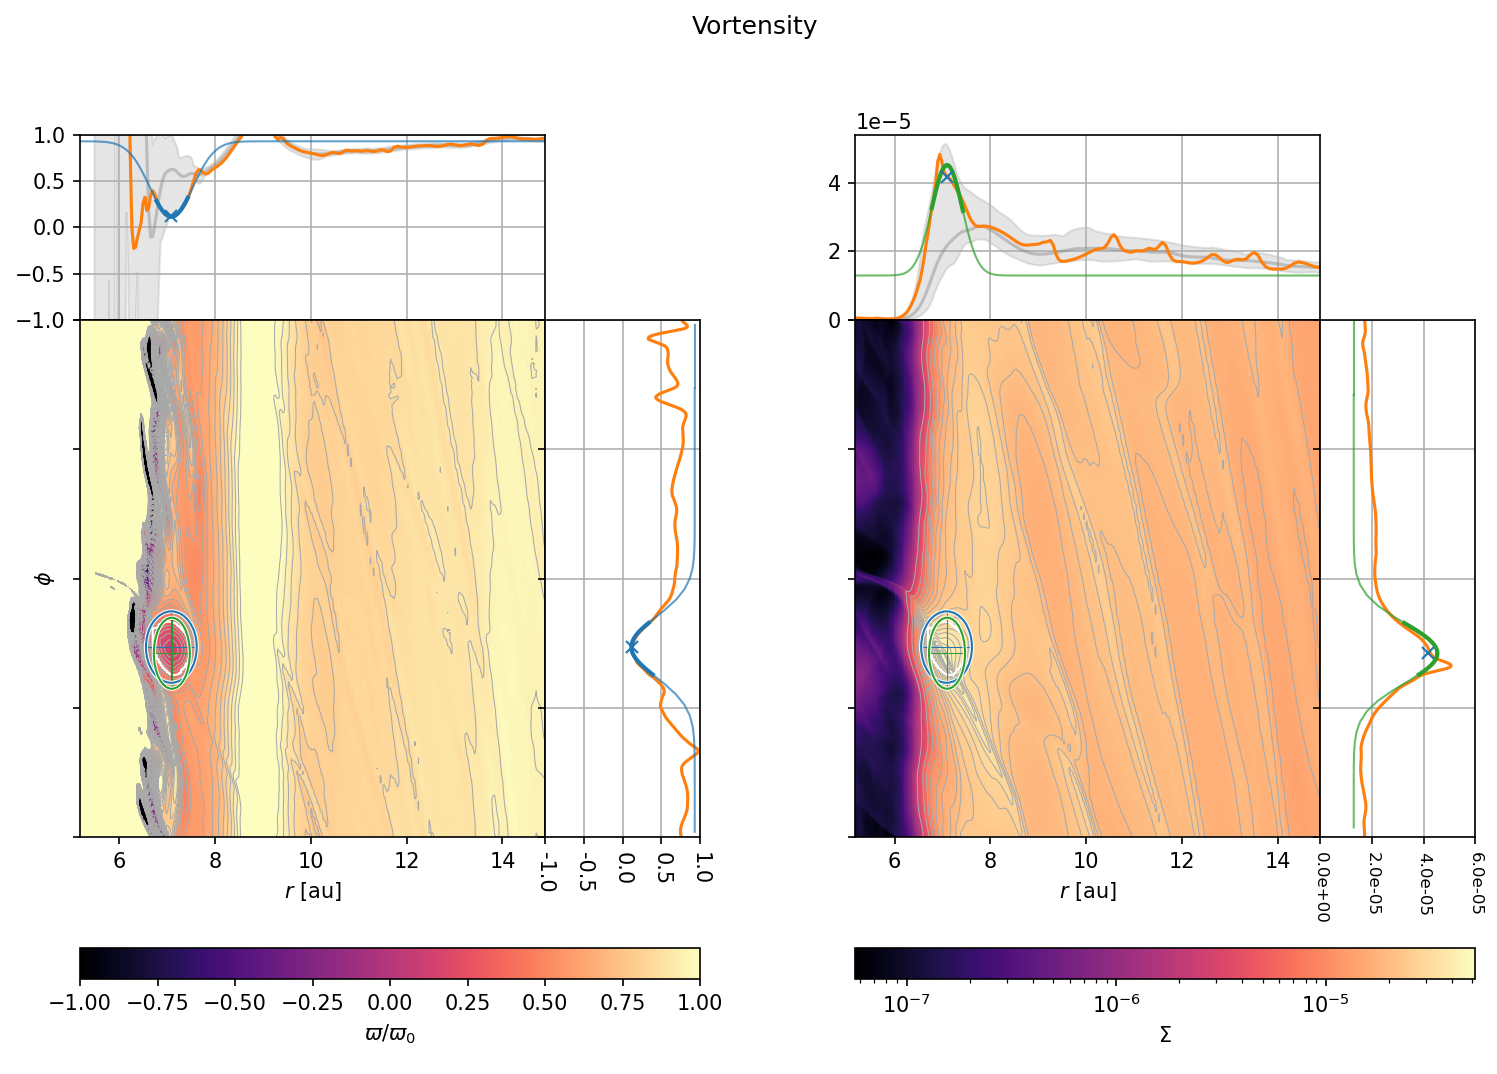

In [82]:
%matplotlib inline

vd = Vortector(R, Phi, A, vorticity/vorticity_Kepler-1, Rho, levels=np.linspace(-1,0,41))
%time vortices = vd.detect(include_mask=True, keep_internals=True, blur=0)
fig = show_fit_overview_2D(vd)#, xscale="log")
fig.suptitle("Vorticity")
for ax in fig.axes:
    if ax.get_xlabel() == r"$\varpi/\varpi_0$":
        ax.set_xlabel(r"$(\nabla \times \vec{v})_z \,/\, 0.5 \Omega_\mathrm{K} - 1$")


vd = Vortector(R, Phi, A, vorticity/vorticity_Kepler*Rho_background/Rho, Rho, levels=np.linspace(-1,1,41), med=0.15)
%time vortices = vd.detect(include_mask=True, keep_internals=True, blur=0)
fig = show_fit_overview_2D(vd)#, xscale="log")
fig.suptitle("Vortensity")

## Lovelace Parameter

Defined in Lovelace et al. 1999, the Lovelace parameter give a measure of where the Rosby Wave instability can be triggered.

\begin{align}
\mathcal{L} = \frac{S^{2/\gamma}}{\bar{\omega}}
\end{align}

with the entropy, $S$, the adiabatic index ,$\gamma$, and the vortensity, $\bar{\omega} = \frac{\omega}{\Sigma}$.
$\omega = \hat{z}\cdot (\nabla \times \vec{v})$ is the vorticity.

Using $S = \frac{P}{\Sigma^\gamma}$

\begin{align}
\mathcal{L} = \frac{P^{2/\gamma}}{\Sigma \omega}
\end{align}

Simplifying this even further with $P=\Sigma\, c_{s,\mathrm{iso}}^2$

\begin{align}
\mathcal{L} = \frac{\Sigma^{2/\gamma -1}c_{s,\mathrm{iso}}^{4/\gamma} }{\omega}
\end{align}

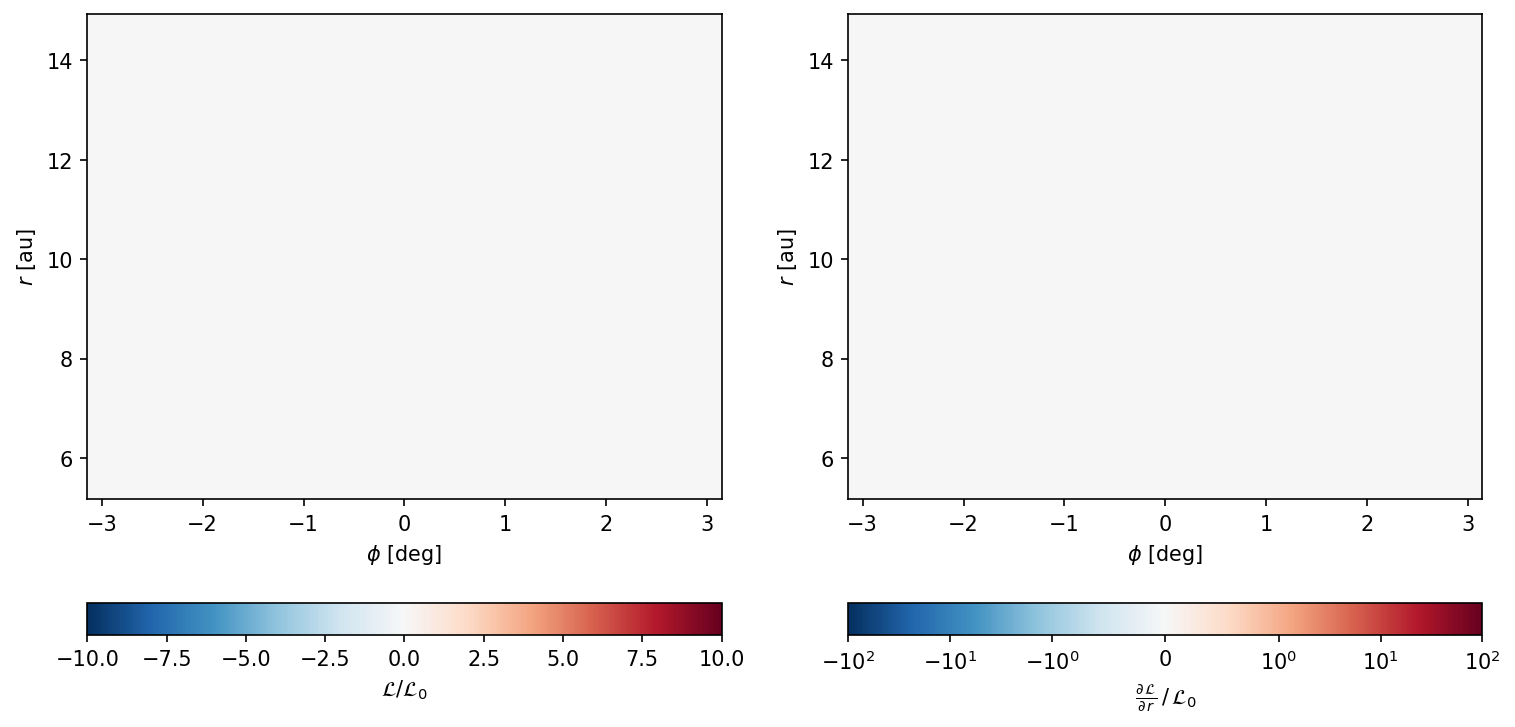

In [42]:
Lovelace = P**(2/gamma)/Rho/vorticity
Lovelace0 = P0[0,0]**(2/gamma)/Rho0[0]/vorticity_Kepler[0,0]

fig, axes = plt.subplots(1,2,dpi=150, figsize=(12,6))

ax = axes[0]
vscale = 10
vmin, vmax = -vscale, vscale
Q = Lovelace/Lovelace0
im = ax.pcolormesh(Phi, R, Q,
                   cmap="RdBu_r", 
#                    norm=colors.SymLogNorm(
#                        linthresh = vscale/100, vmin=vmin, vmax=vmax)
                   vmin=vmin, vmax=vmax,
                  )
# ax.contour(Phi, R, Q, cmap="Greys", levels=np.geomspace(1e-2*vscale, vscale, 20), linewidths=0.5)
ax.set_xlabel("$\phi$ [deg]")
ax.set_ylabel("$r$ [au]")
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\mathcal{L}/\mathcal{L}_0$")

ax = axes[1]
vscale = 100
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, np.gradient(Lovelace, R[:,0], axis=0)/Lovelace0,
                   cmap="RdBu_r", 
                   norm=colors.SymLogNorm(
                       linthresh = 1e-2*vscale, vmin=vmin, vmax=vmax)
                  )
ax.set_xlabel("$\phi$ [deg]")
ax.set_ylabel("$r$ [au]")
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\frac{\partial\,\mathcal{L}}{\partial\,r} \, /\, \mathcal{L}_0$")

for vort in vd.vortices:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="Grey", linewidths=0.5)
        r, phi = vort["contour"]["stats"]["vortensity_min_pos"]
        ax.plot([phi], [r], "x", color="Grey")

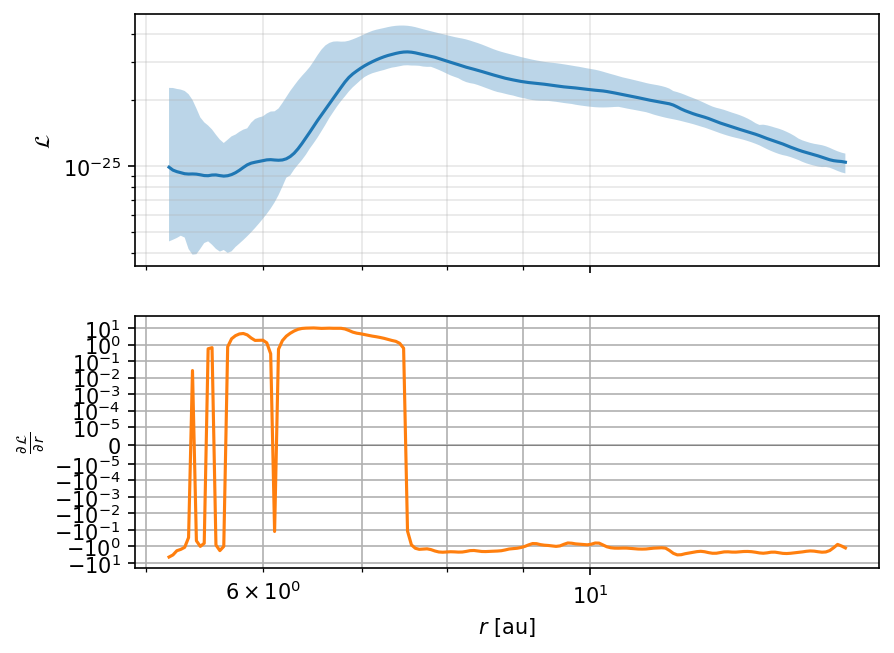

In [43]:
fig, axes = plt.subplots(2,1,dpi=150, sharex="all")

Q = Lovelace
ax = axes[0]
ax.plot(R[:,0], np.average(Q, axis=1))
ax.fill_between(R[:,0], np.min(Q, axis=1), np.max(Q, axis=1), alpha=0.3)

# vmin = 1e-6
# ax.set_ylim(bottom=vmin)
ax.set_yscale("log")
ax.set_ylabel("$\mathcal{L}$")
ax.set_xscale("log")
ax.grid(alpha=0.3)
ax.grid(alpha=0.3, which="minor")

ax = axes[1]
Q = np.gradient(np.log(Lovelace), np.log(R[:,0]), axis=0)
ax.axhline(0, alpha=0.3, color="k", lw=0.5)
ax.plot(R[:,0], np.average(Q, axis=1), color="C1")
# ax.fill_between(R[:,0], np.min(Q, axis=1), np.max(Q, axis=1), alpha=0.3, color="C1")
ax.set_yscale("symlog", linthresh=1e-5)
ax.set_xlabel("$r$ [au]")
ax.set_ylabel(r"$\frac{\partial\,\mathcal{L}}{\partial\,r}$")
# ax.set_xscale("log")
ax.grid()
ax.grid(which="minor")

## Velocitity and vorticity deviations from Keplerian

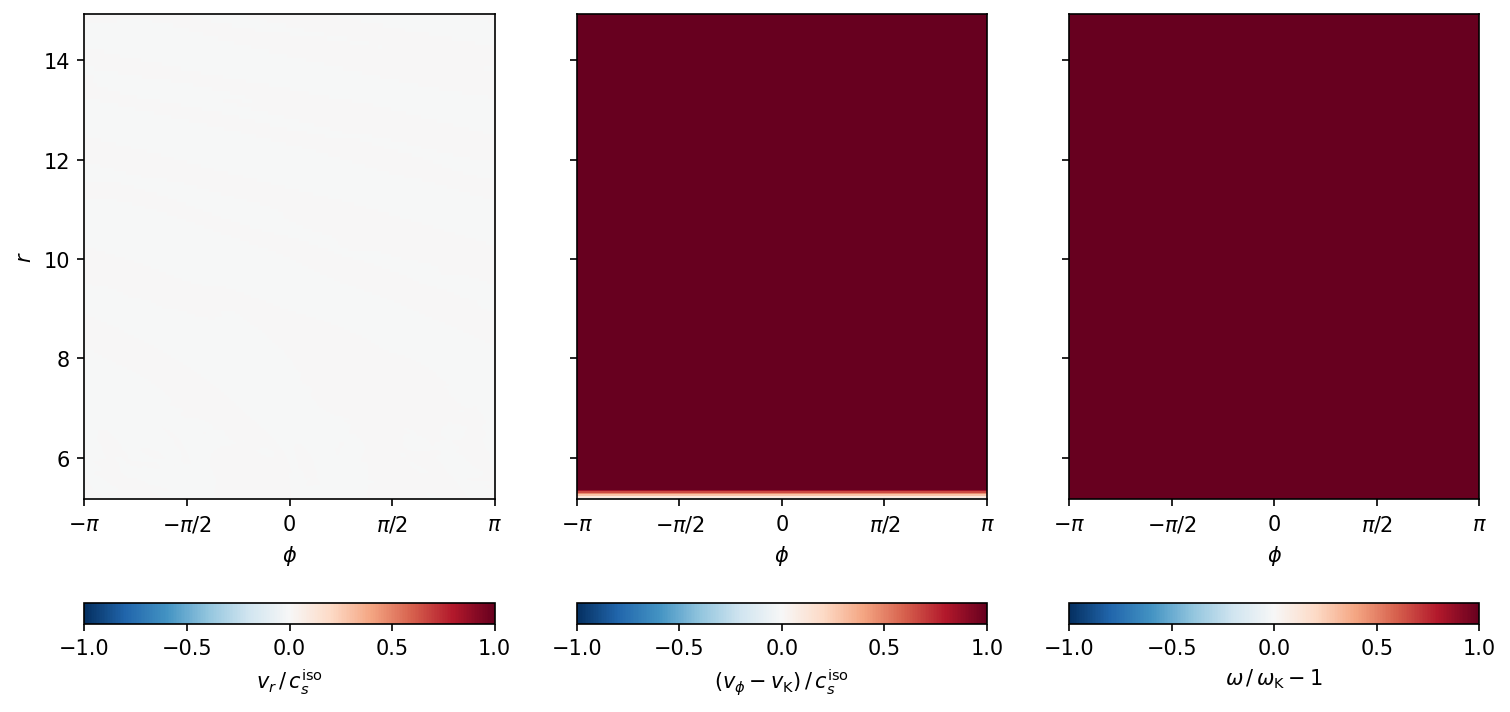

In [44]:
%matplotlib inline
fig, axes = plt.subplots(1,3,sharey="all", dpi=150, figsize=(12,6))

cbar_orientation = "horizontal"
# cbar_orientation = "vertical"

ax = axes[0]
vscale = 1
vmin, vmax = -vscale, vscale

im = ax.pcolormesh(Phi, R, Vr/Cs_iso, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$v_r \,/\, c_s^\mathrm{iso}$")

ax = axes[1]
vscale = 1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, (Vphi-Vk)/Cs_iso, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$(v_\phi - v_\mathrm{K}) \,/\, c_s^\mathrm{iso}$")

ax = axes[2]
vscale = 1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, vorticity/vorticity_Kepler -1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$\omega\,/\,\omega_\mathrm{K} -1$")

for vort in vd.vortices:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="Grey", linewidths=0.5)
        r, phi = vort["contour"]["stats"]["vortensity_min_pos"]
        ax.plot([phi], [r], "x", color="Grey")

axes[0].set_ylabel("$r$")
for ax in axes:
    ax.set_xticks(np.array([-1,-0.5,0,0.5,1])*np.pi)
    ax.set_xticklabels(["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
    ax.set_xlabel("$\phi$")


## Velocity quiver plot of the whole domain

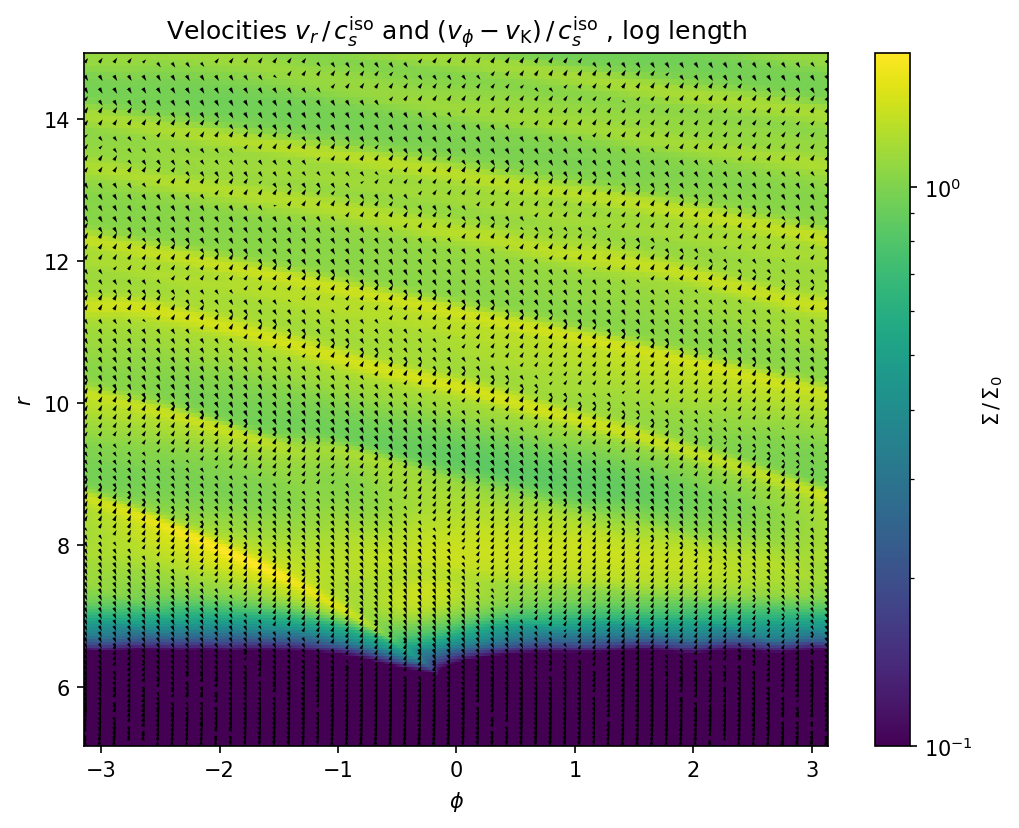

In [46]:
# %matplotlib widget
fig, axes = plt.subplots(nrows=1,ncols=1,dpi=150, figsize=(8,6))
axes = [axes]
cbar_quiver = None

Nsub = 2

def zoomed_quiver(ax, R, Phi, Vr, Vphi, sub=(1,1), bb=[[0,-1],[0,-1]]):
    xl, xu, yl, yu = bb[0][0], bb[0][1], bb[1][0], bb[1][1]
    if xu < xl:
        xl, xu = 0, -1
    if yu < yl:
        yl, yu = 0, -1
    sx, sy = sub
    X = R[xl:xu:sx, yl:yu:sy]
    Y = Phi[xl:xu:sx, yl:yu:sy]
    U = Vr[xl:xu:sx, yl:yu:sy]
    V = Vphi[xl:xu:sx, yl:yu:sy]
    U = np.sign(U)*np.log( np.abs(U)/np.min(np.abs(U)) )
    V = np.sign(V)*np.log( np.abs(V)/np.min(np.abs(V)) )
    ax.quiver(X, Y, U, V, units="xy")

for ax in axes:
    im = ax.pcolormesh(Phi, R, Rho/Rho_background, norm=colors.LogNorm(vmin=1e-1))
    
zoomed_quiver(
    axes[0], 
    Phi, R,
    ((Vphi - Vk)/Cs_iso).decompose().value,
    (Vr/Cs_iso).decompose().value,
    sub=(Nsub,Nsub*10)
)

if cbar_quiver is None:
    cbar_quiver = fig.colorbar(im, ax=axes[-1], orientation="vertical")
    cbar_quiver.set_label(r"$\Sigma\,/\,\Sigma_0$")

for vort in vd.vortices:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C3", linewidths=0.5, levels=[0.5])

ax.set_xlabel("$\phi$")
ax.set_ylabel("$r$")

ax.set_title("Velocities $v_r\,/\,c_s^\mathrm{iso}$ and $(v_\phi - v_\mathrm{K})\,/\,c_s^\mathrm{iso}$ , log length");

### Zoomin to the main vortex

In [47]:
try:
    vd.vortices[0]
    %matplotlib widget
    fig, axes = plt.subplots(nrows=1,ncols=1,dpi=150, figsize=(8,6))
    axes = [axes]
    cbar_quiver = None

    Nsub = 1

    def zoomed_quiver(ax, R, Phi, Vr, Vphi, sub=(1,1), bb=[[0,-1],[0,-1]]):
        xl, xu, yl, yu = bb[0][0], bb[0][1], bb[1][0], bb[1][1]
        if xu < xl:
            xl, xu = 0, -1
        if yu < yl:
            yl, yu = 0, -1
        sx, sy = sub
        X = R[xl:xu:sx, yl:yu:sy]
        Y = Phi[xl:xu:sx, yl:yu:sy]
        U = Vr[xl:xu:sx, yl:yu:sy]
        V = Vphi[xl:xu:sx, yl:yu:sy]
        U = np.sign(U)*np.log( np.abs(U)/np.min(np.abs(U)) )
        V = np.sign(V)*np.log( np.abs(V)/np.min(np.abs(V)) )
        ax.quiver(X, Y, U, V, units="xy")


    R_vort, Phi_vort, Vortensity_vort, Rho_vort, Mask_vort, Vphi_vort, Vr_vort = vd.extract_data(vd.vortices[0], aux_fields=[((Vphi - Vk)/Cs_iso).decompose().value, (Vr/Cs_iso).decompose().value])

    for ax in axes:
        im = ax.pcolormesh(Phi_vort, R_vort, Rho_vort/np.max(Rho_vort), norm=colors.LogNorm(vmin=1e-1))

    zoomed_quiver(
        axes[0], 
        Phi_vort, R_vort,
        Vphi_vort,
        Vr_vort,
        sub=(Nsub,Nsub*20)
    )

    if cbar_quiver is None:
        cbar_quiver = fig.colorbar(im, ax=axes[-1], orientation="vertical")
        cbar_quiver.set_label(r"$\Sigma\,/\,\Sigma_0$")

    for vort in vd.vortices:
        for ax in axes:
            ax.contour(Phi_vort, R_vort, Mask_vort, colors="C3", linewidths=0.5, levels=[0.5])

    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$r$")

    ax.set_title("Velocities $v_r\,/\,c_s^\mathrm{iso}$ and $(v_\phi - v_\mathrm{K})\,/\,c_s^\mathrm{iso}$ , log length");
except IndexError:
    pass

## Velocity gradients

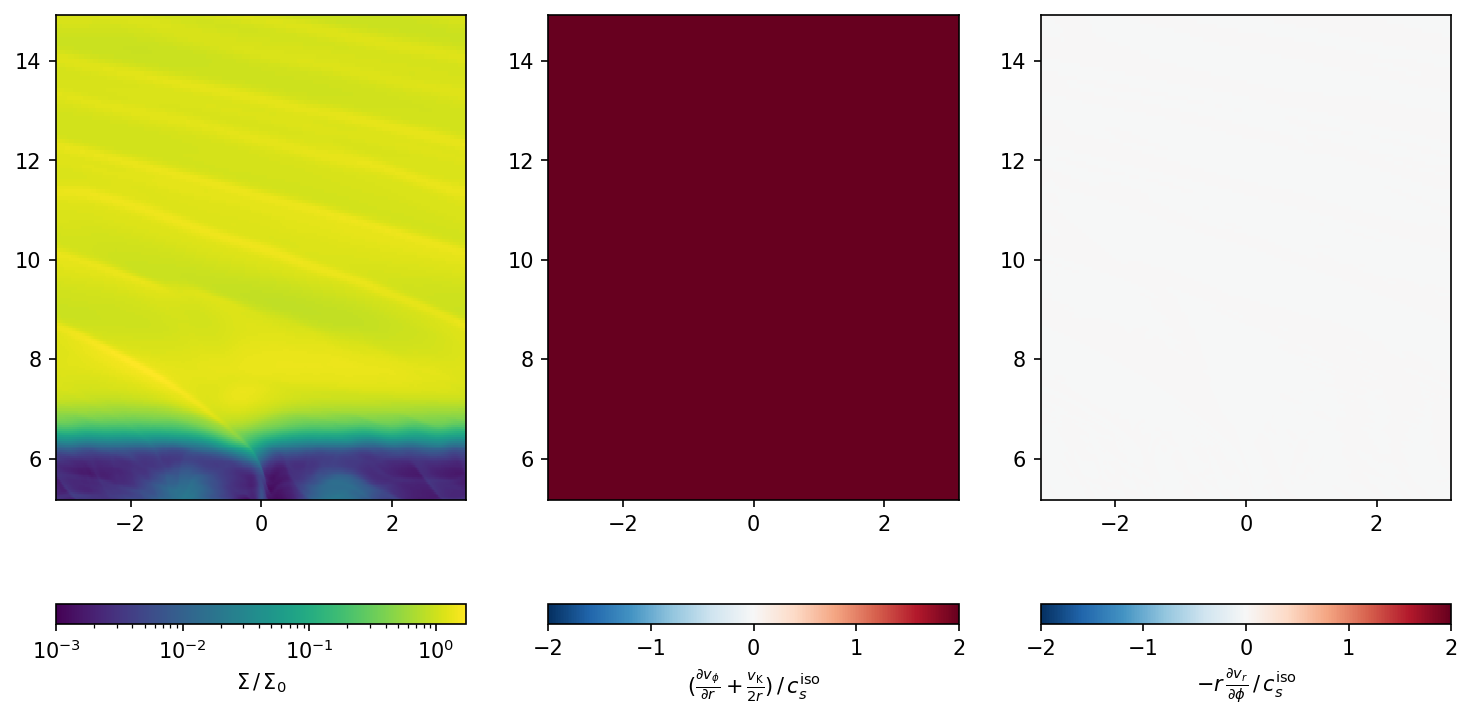

In [48]:
%matplotlib inline
from matplotlib.colors import LogNorm
dvphi_dr = np.gradient(Vphi, R[:,0], axis=0)
dvr_dphi = np.gradient(Vr, Phi[0], axis=1)

fig, axes = plt.subplots(1,3,dpi=150, figsize=(12,6))

ax = axes[0]
vmin, vmax = 1e-3, None
im = ax.pcolormesh(Phi, R, Rho/Rho_background, cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\Sigma \,/\, \Sigma_0$")

ax = axes[1]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, (dvphi_dr + Vk/R/2)/Cs_iso, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$(\frac{\partial v_\phi}{\partial r} + \frac{v_\mathrm{K}}{2r})\,/\, c_s^\mathrm{iso}$")

ax = axes[2]
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, -dvr_dphi/Cs_iso/R, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$-r \, \frac{\partial v_r}{\partial \phi}  \,/\, c_s^\mathrm{iso}$")

# show vortex contour
for vort in vd.vortices:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C3", linewidths=0.5)

## Pressure and pressure gradients

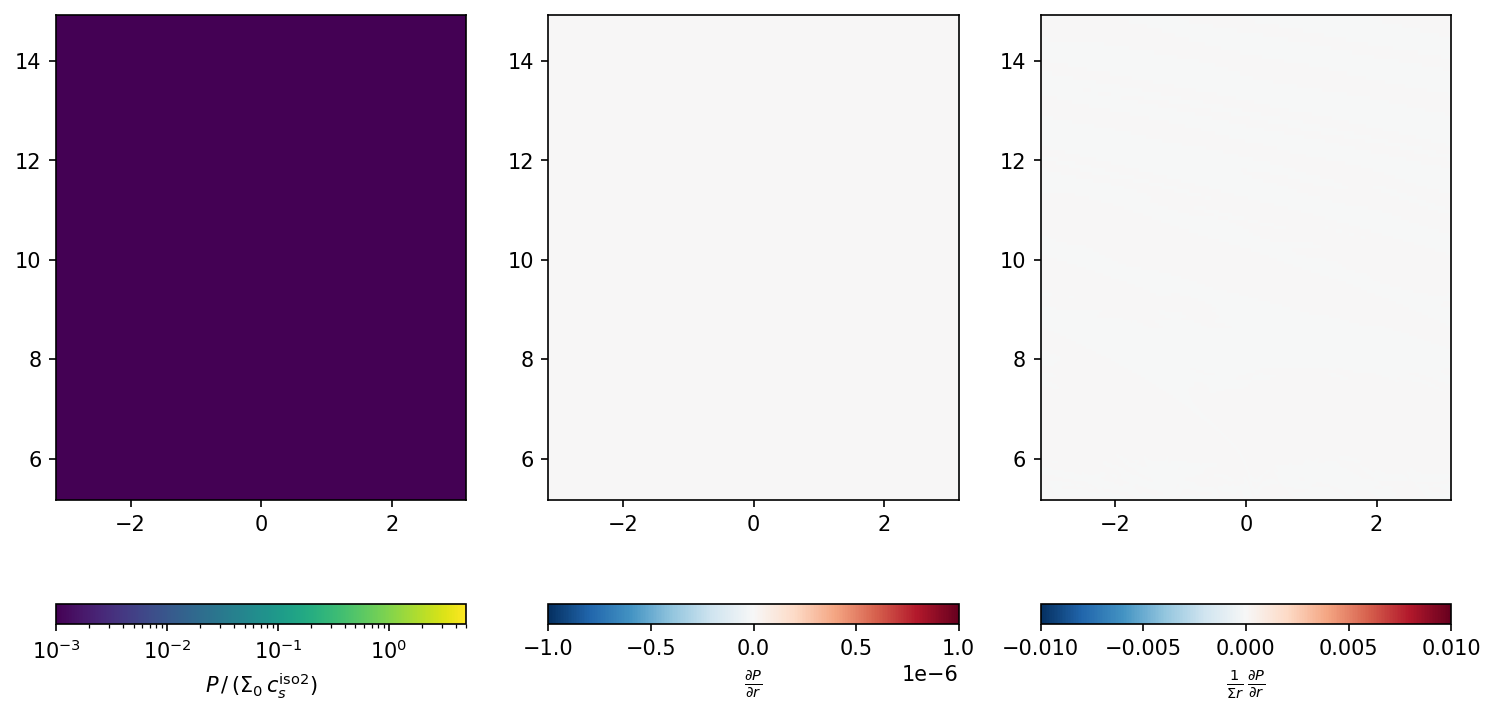

In [49]:
%matplotlib inline
from matplotlib.colors import LogNorm
dvphi_dr = np.gradient(Vphi, R[:,0], axis=0)
dvr_dphi = np.gradient(Vr, Phi[0], axis=1)

fig, axes = plt.subplots(1,3,dpi=150, figsize=(12,6))

ax = axes[0]
vmin, vmax = 1e-3, 5
im = ax.pcolormesh(Phi, R, P/P0, cmap="viridis", norm=colors.LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$P\,/\,(\Sigma_0\,{c_s^\mathrm{iso}}^2)$")

dP_dr = np.gradient(P, R[:,0], axis=0)

ax = axes[1]
vscale = 1e-6
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dP_dr , cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\frac{\partial P}{\partial r}$")

ax = axes[2]
vscale = 1e-2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dP_dr/Rho/R, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\frac{1}{\Sigma r}\,\frac{\partial P}{\partial r}$")


# show vortex contour
for vort in vd.vortices:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C3", linewidths=0.5)

## Contributions from density and sound speed gradients to vorticity

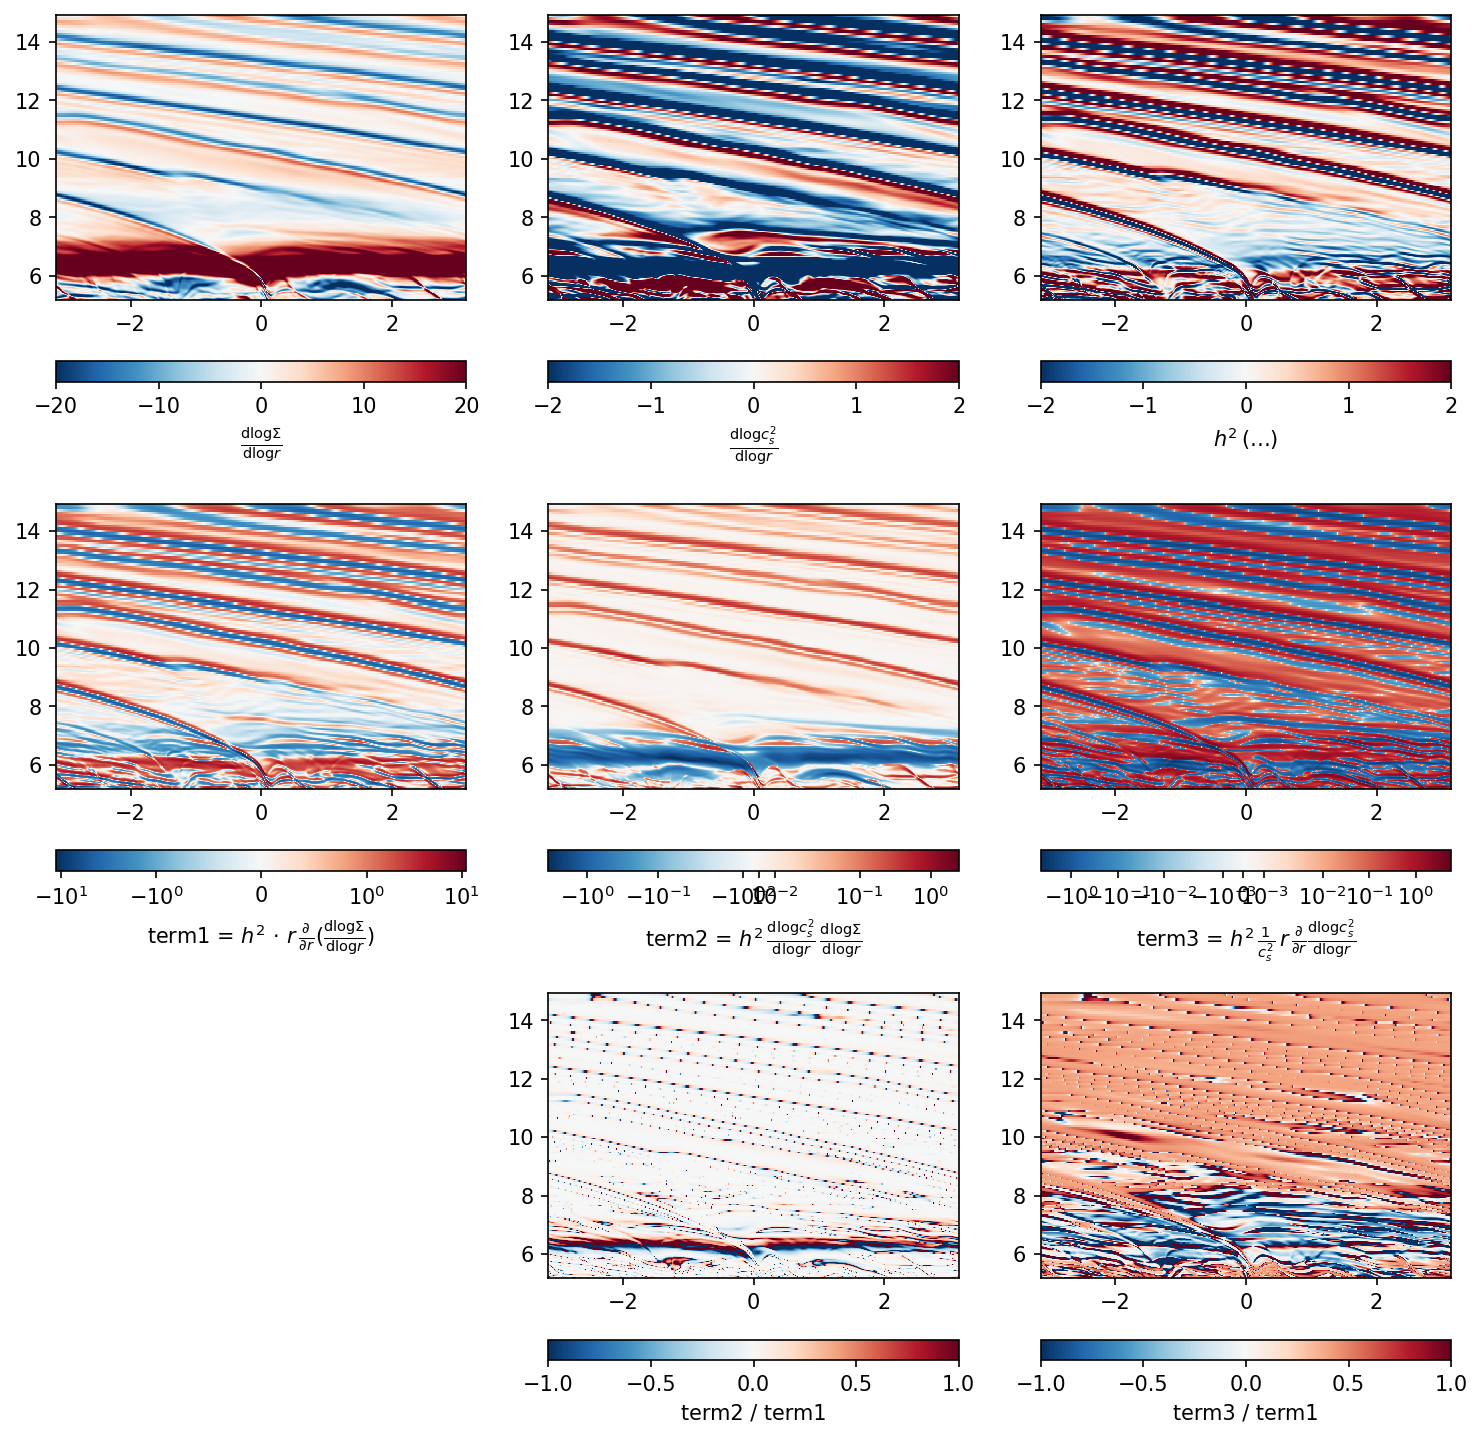

In [50]:
%matplotlib inline
fig, axes = plt.subplots(3,3,dpi=150, figsize=(12,12))
# axes=axes.ravel()
s = np.gradient(np.log(Rho), R[:,0], axis=0)
ds_dr = np.gradient(R*s, R[:,0], axis=0)
dlogSigma_dlogr = np.gradient(np.log(Rho), np.log(R[:,0]), axis=0)

dlogcs2_dlogr = np.gradient(np.log(Cs2_adb), np.log(R[:,0]), axis=0)

term1 = R*ds_dr*h**2
term2 = h**2*dlogcs2_dlogr * dlogSigma_dlogr
term3 = h**2* np.gradient(Cs2_adb*dlogcs2_dlogr, np.log(R[:,0]), axis=0) / Cs2_adb

gamma = 1.4
h = 0.05

ax = axes[0,0]
vscale = 20
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dlogSigma_dlogr, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}$")

ax = axes[0,1]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dlogcs2_dlogr, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\frac{\mathrm{d log} c_s^2}{\mathrm{d log}r}$")

ax = axes[0,2]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term1+term2+term3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$h^2 \,(\dots)$")

ax = axes[1,0]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term1, cmap="RdBu_r", norm=colors.SymLogNorm(linthresh=1))#, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"term1 = $h^2\,\cdot\, r\, \frac{\partial}{\partial r}  (\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r})$")

ax = axes[1,1]
vscale = 0.1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term2, cmap="RdBu_r", norm=colors.SymLogNorm(linthresh=h))#, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"term2 = $h^2 \,\frac{\mathrm{d log} c_s^2}{\mathrm{d log}r}\,\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}$")

ax = axes[1,2]
vscale = 0.01
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term3, cmap="RdBu_r", norm=colors.SymLogNorm(linthresh=h**2))#, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"term3 = $h^2 \, \frac{1}{c_s^2} \,r\, \frac{\partial}{\partial r} \frac{\mathrm{d log} c_s^2}{\mathrm{d log}r}$")

ax = axes[2,1]
vscale = 1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term2/term1, cmap="RdBu_r", vmin=vmin, vmax=vmax)#, norm=colors.SymLogNorm(linthresh=h))#, 
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label("term2 / term1")

ax = axes[2,2]
vscale = 1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term3/term1, cmap="RdBu_r", vmin=vmin, vmax=vmax)#, norm=colors.SymLogNorm(linthresh=h**2))#, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label("term3 / term1")

axes[2,0].remove()


# show vortex contour
for vort in vd.vortices:
    for ax in axes.ravel():
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C2", linewidths=0.5)

Text(0, 0.5, '$\\frac{\\mathrm{d log} \\Sigma}{\\mathrm{d log}r}$')

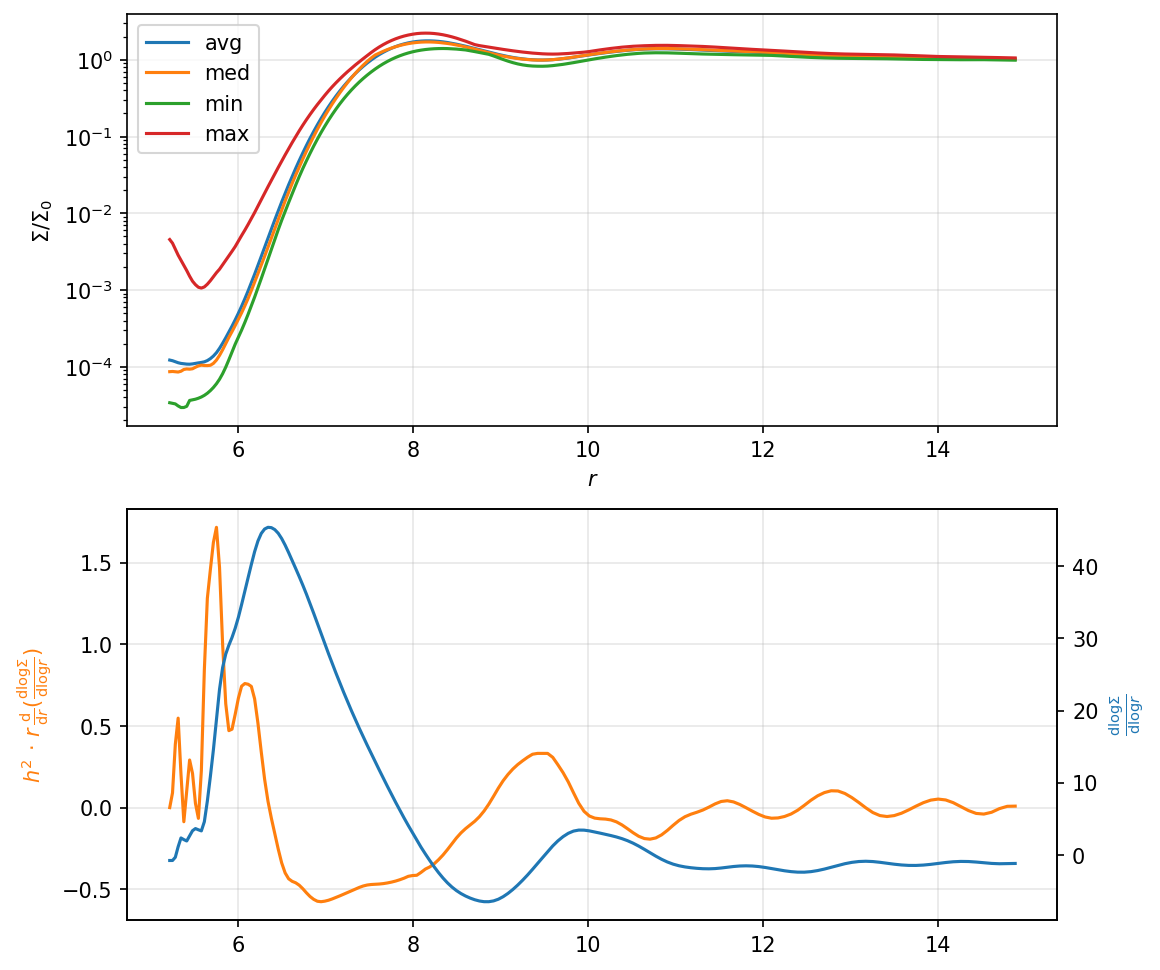

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(2,1,dpi=150, figsize=(8,8))

ax = axes[0]
Z = Rho
ax.plot(R[:,0], np.average(Z, axis=1)/Rho0, label="avg")
ax.plot(R[:,0], np.median(Z, axis=1)/Rho0, label="med")
ax.plot(R[:,0], np.min(Z, axis=1)/Rho0, label="min")
ax.plot(R[:,0], np.max(Z, axis=1)/Rho0, label="max")
ax.set_yscale("log")
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel("$r$")
ax.set_ylabel("$\Sigma/\Sigma_0$")

gamma = 1.4
h = 0.05

ax = axes[1]
ax.plot(R[:,0], np.average(h**2*R*ds_dr, axis=1), color="C1")
ax.set_ylabel(r"$h^2 \,\cdot\, r\, \frac{\mathrm{d}}{\mathrm{d}r}  (\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}) $", color="C1")
ax.grid(alpha=0.3)
ax2 = ax.twinx()
ax2.plot(R[:,0], np.average(R*s, axis=1), color="C0")
ax2.set_ylabel(r"$\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}$", color="C0")

## Temperature

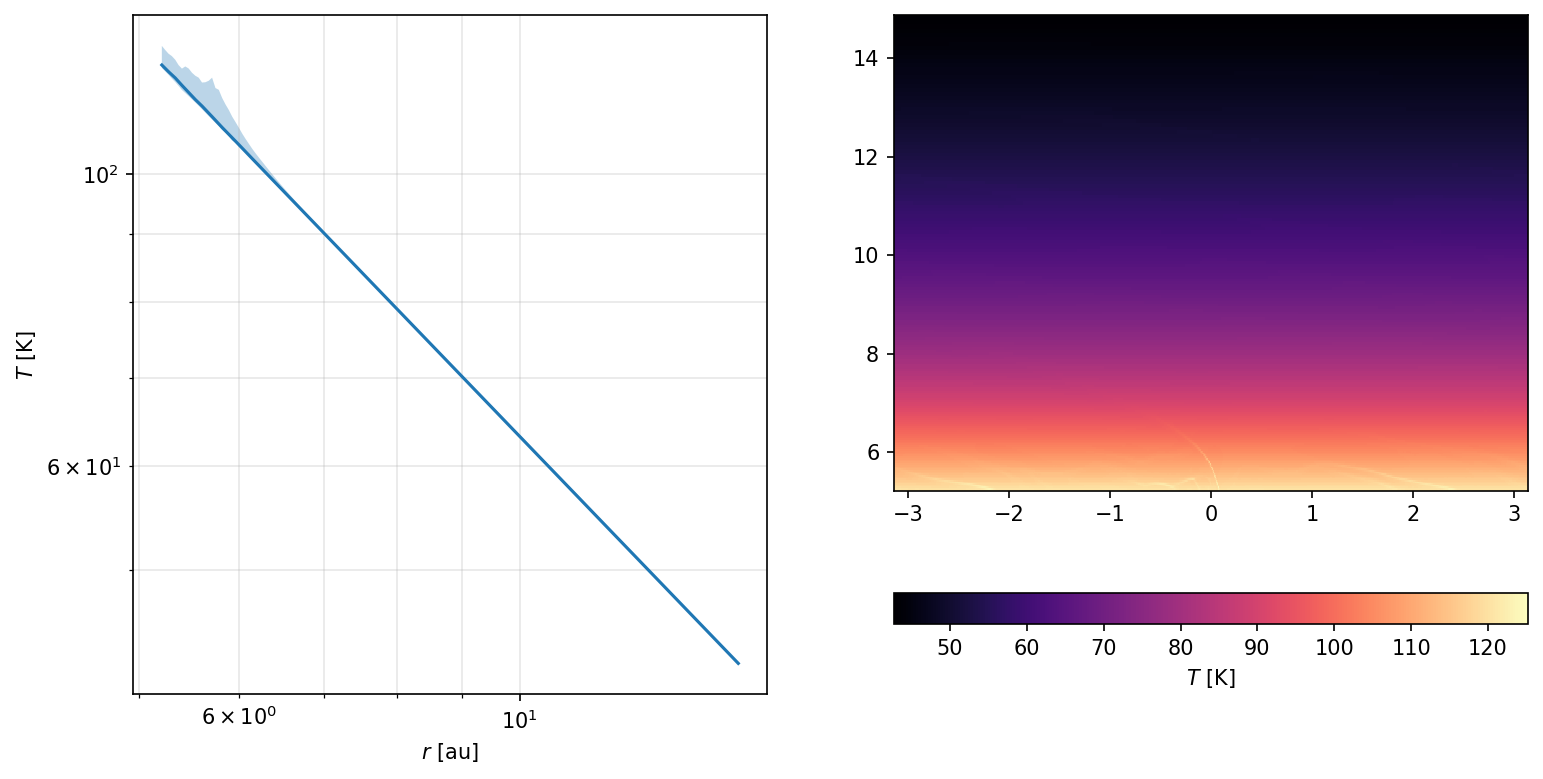

In [ ]:
fig, axes = plt.subplots(1,2,dpi=150, figsize=(12,6))

ax = axes[0]
ax.plot(R[:,0], np.average(T, axis=1))
ax.fill_between(R[:,0], np.min(T, axis=1), np.max(T, axis=1), alpha=0.3)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=0.3, which="minor")
ax.grid(alpha=0.3, which="major")
ax.set_xlabel("$r$ [au]")
ax.set_ylabel("$T$ [K]")

ax = axes[1]
vmin, vmax = 1, 300
im = ax.pcolormesh(Phi, R, T, cmap="magma")#, norm=colors.LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$T$ [K]")

## Surface density

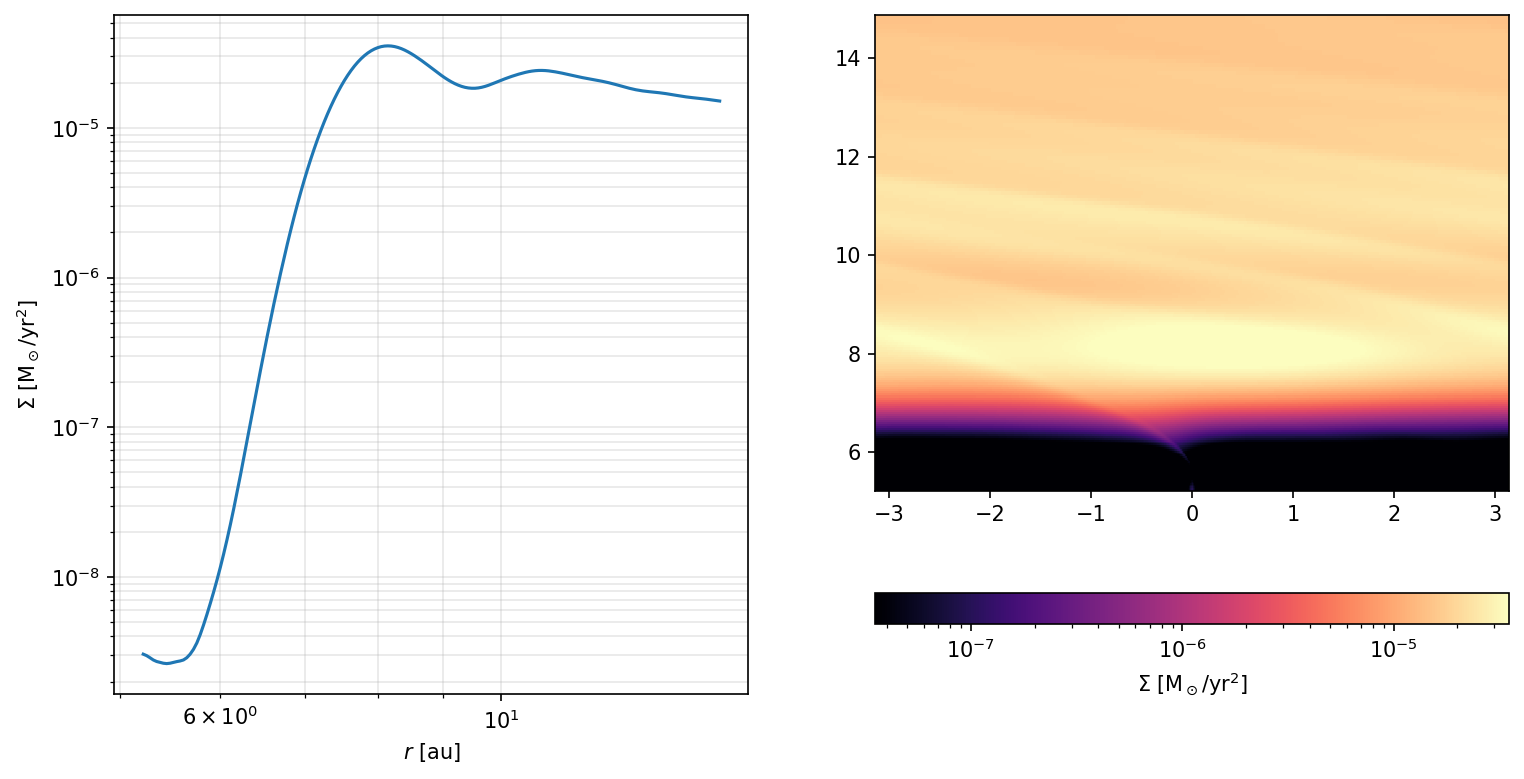

In [ ]:
fig, axes = plt.subplots(1,2,dpi=150, figsize=(12,6))

ax = axes[0]
ax.plot(R[:,0], np.average(Rho, axis=1))
# ax.fill_between(R[:,0], np.min(T, axis=1), np.max(T, axis=1), alpha=0.3)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=0.3, which="minor")
ax.grid(alpha=0.3, which="major")
ax.set_xlabel("$r$ [au]")
ax.set_ylabel("$\Sigma$ [M$_\odot$/yr$^2$]")

ax = axes[1]
vmax = np.max(np.average(Rho, axis=1))
vmin = 1e-3 * vmax
im = ax.pcolormesh(Phi, R, Rho, cmap="magma", norm=colors.LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\Sigma$ [M$_\odot$/yr$^2$]")

## Streamlines inside the vortex

(100, 100)
(100, 100)


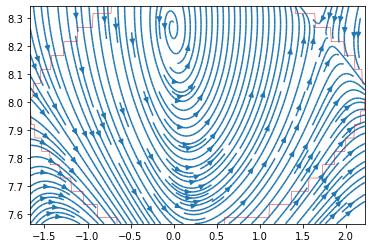

In [ ]:
R_vort, Phi_vort, Vortensity_vort, Rho_vort, Mask_vort, Vphi_vort, Vr_vort = vd.extract_data(vd.vortices[0], aux_fields=[((Vphi - Vk)/Cs_iso).decompose().value, (Vr/Cs_iso).decompose().value])

from scipy.interpolate import griddata

Ninterp = 100
xi = np.linspace(R_vort[0,0], R_vort[-1,0], Ninterp)
yi = np.linspace(Phi_vort[0,0], Phi_vort[0,-1], Ninterp)
Xi, Yi = np.meshgrid(xi, yi)
# define grid.
# grid the data.
print(Xi.shape)
print(Yi.shape)
Ui = griddata((R_vort.ravel(), Phi_vort.ravel()), Vr_vort.ravel(), (Xi, Yi), method='cubic')
Vi = griddata((R_vort.ravel(), Phi_vort.ravel()), Vphi_vort.ravel(), (Xi, Yi), method='cubic')
fig, ax = plt.subplots()
ax.streamplot(Yi.T, Xi.T, Vi.T, Ui.T, density=2)

ax.contour(Phi_vort, R_vort, Mask_vort, colors="C3", linewidths=0.5, levels=[0.5])


In [ ]:
Xi.shape

(100, 100)

In [ ]:
Xi

array([[7.56534289, 7.57317244, 7.58100199, ..., 8.32480918, 8.33263873,
        8.34046828],
       [7.56534289, 7.57317244, 7.58100199, ..., 8.32480918, 8.33263873,
        8.34046828],
       [7.56534289, 7.57317244, 7.58100199, ..., 8.32480918, 8.33263873,
        8.34046828],
       ...,
       [7.56534289, 7.57317244, 7.58100199, ..., 8.32480918, 8.33263873,
        8.34046828],
       [7.56534289, 7.57317244, 7.58100199, ..., 8.32480918, 8.33263873,
        8.34046828],
       [7.56534289, 7.57317244, 7.58100199, ..., 8.32480918, 8.33263873,
        8.34046828]])

In [ ]:
import plotly.figure_factory as ff

import numpy as np

# Create streamline figure
fig = ff.create_streamline(Xi[0], Yi[:,0], Ui, Vi, arrow_scale=.1, density=2)
fig.show()